In [1]:
import pandas as pd
import numpy as np
import json  # Para parsear .geo
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Definir rangos de años
years = range(2020, 2025)  # De 2020 a 2024 inclusive

# Listas para acumular dataframes procesados
modis_list = []
no_incendios_list = []

# Loop para cargar y procesar modis (incendios positivos)
for year in years:
    modis_file = f'../Incendios/modis_{year}_Peru.csv'
    if os.path.exists(modis_file):
        modis_df_year = pd.read_csv(modis_file)

        # Filtrar a región de San Martín
        san_martin_modis_year = modis_df_year[
            (modis_df_year['latitude'] >= -7.5) & (modis_df_year['latitude'] <= -5.5) &
            (modis_df_year['longitude'] >= -77.5) & (modis_df_year['longitude'] <= -75.5)
        ]

        # Agregar label
        san_martin_modis_year['incendio'] = 1

        # Seleccionar columnas relevantes
        san_martin_modis_year = san_martin_modis_year[['acq_date', 'latitude', 'longitude', 'incendio']]

        modis_list.append(san_martin_modis_year)
        print(f"Cargado y filtrado modis_{year}: {len(san_martin_modis_year)} registros")
    else:
        print(f"Archivo no encontrado: {modis_file}")

# Loop para cargar y procesar no_incendios (negativos)
for year in years:
    no_incendios_file = f'../NoIncendios/puntos_sin_incendio_sanmartin_{year}.csv'
    if os.path.exists(no_incendios_file):
        no_incendios_df_year = pd.read_csv(no_incendios_file)

        # Parsear .geo para extraer lon y lat
        no_incendios_df_year['longitude'] = no_incendios_df_year['.geo'].apply(lambda x: json.loads(x)['coordinates'][0])
        no_incendios_df_year['latitude'] = no_incendios_df_year['.geo'].apply(lambda x: json.loads(x)['coordinates'][1])

        # Filtrar a región de San Martín
        no_incendios_df_year = no_incendios_df_year[
            (no_incendios_df_year['latitude'] >= -7.5) &
            (no_incendios_df_year['latitude'] <= -5.5) &
            (no_incendios_df_year['longitude'] >= -77.5) &
            (no_incendios_df_year['longitude'] <= -75.5)
        ]

        # Agregar label
        no_incendios_df_year['incendio'] = 0

        # Seleccionar columnas relevantes
        no_incendios_df_year = no_incendios_df_year[['acq_date', 'latitude', 'longitude', 'incendio']]

        no_incendios_list.append(no_incendios_df_year)
        print(f"Cargado no_incendios_{year}: {len(no_incendios_df_year)} registros")
    else:
        print(f"Archivo no encontrado: {no_incendios_file}")

# Combinar todos los dataframes
all_modis = pd.concat(modis_list, ignore_index=True) if modis_list else pd.DataFrame()
all_no_incendios = pd.concat(no_incendios_list, ignore_index=True) if no_incendios_list else pd.DataFrame()
full_df = pd.concat([all_modis, all_no_incendios], ignore_index=True)

# Ver totales
print(f"Total incendios: {len(all_modis)}")
print(f"Total no incendios: {len(all_no_incendios)}")
print(f"Dataset completo: {len(full_df)}")
full_df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_6184\1346043345.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  san_martin_modis_year['incendio'] = 1
C:\Users\User\AppData\Local\Temp\ipykernel_6184\1346043345.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  san_martin_modis_year['incendio'] = 1
C:\Users\User\AppData\Local\Temp\ipykernel_6184\1346043345.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

Cargado y filtrado modis_2020: 2034 registros
Cargado y filtrado modis_2021: 2199 registros
Cargado y filtrado modis_2022: 2609 registros
Cargado y filtrado modis_2023: 2177 registros
Cargado y filtrado modis_2024: 2599 registros
Cargado no_incendios_2020: 1509 registros
Cargado no_incendios_2021: 1497 registros
Cargado no_incendios_2022: 1466 registros
Cargado no_incendios_2023: 1479 registros
Cargado no_incendios_2024: 1473 registros
Total incendios: 11618
Total no incendios: 7424
Dataset completo: 19042


,acq_date,latitude,longitude,incendio
0,2020-01-04,-7.0222,-76.2183,1
1,2020-01-04,-7.0182,-76.2119,1
2,2020-01-04,-7.0134,-76.2486,1
3,2020-01-04,-5.8973,-76.1217,1
4,2020-01-05,-6.3638,-76.7512,1


In [3]:
# Convertir acq_date a datetime (maneja errores si hay formatos inconsistentes)
full_df['acq_date'] = pd.to_datetime(full_df['acq_date'], errors='coerce')

# Eliminar rows con fechas inválidas (si hay NaT)
full_df = full_df.dropna(subset=['acq_date'])

# Extraer features temporales
full_df['year'] = full_df['acq_date'].dt.year
full_df['month'] = full_df['acq_date'].dt.month
full_df['day'] = full_df['acq_date'].dt.day
full_df['day_of_year'] = full_df['acq_date'].dt.dayofyear

# Verificar las nuevas columnas
full_df.head()

,acq_date,latitude,longitude,incendio,year,month,day,day_of_year
0,2020-01-04,-7.0222,-76.2183,1,2020,1,4,4
1,2020-01-04,-7.0182,-76.2119,1,2020,1,4,4
2,2020-01-04,-7.0134,-76.2486,1,2020,1,4,4
3,2020-01-04,-5.8973,-76.1217,1,2020,1,4,4
4,2020-01-05,-6.3638,-76.7512,1,2020,1,5,5


In [4]:
features = ['latitude', 'longitude', 'month', 'day', 'day_of_year', 'year']
X = full_df[features]
y = full_df['incendio']

# Ver balance de clases
print(y.value_counts())

incendio
1    11618
0     7424
Name: count, dtype: int64


In [5]:
# Calcular scale_pos_weight para desbalance
scale_pos_weight = sum(y == 0) / sum(y == 1) if sum(y == 1) > 0 else 1
print(f"Scale pos weight: {scale_pos_weight}")

Scale pos weight: 0.6390084351867792


In [6]:
# Dividir en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Crear modelo con scale_pos_weight
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

# Entrenar
model.fit(X_train, y_train)

# Predecir en test
y_pred = model.predict(X_test)

Accuracy (2020-2024): 0.8668941979522184
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1485
           1       0.89      0.89      0.89      2324

    accuracy                           0.87      3809
   macro avg       0.86      0.86      0.86      3809
weighted avg       0.87      0.87      0.87      3809



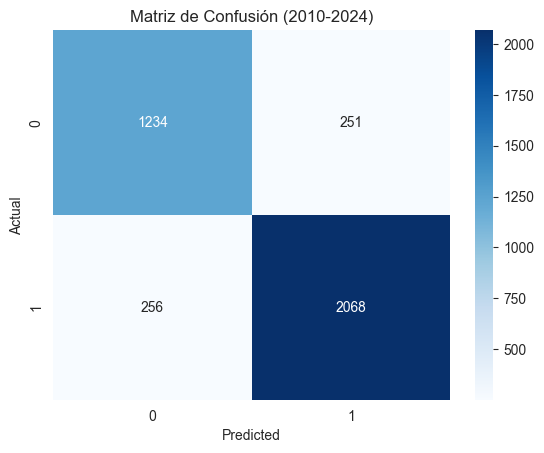

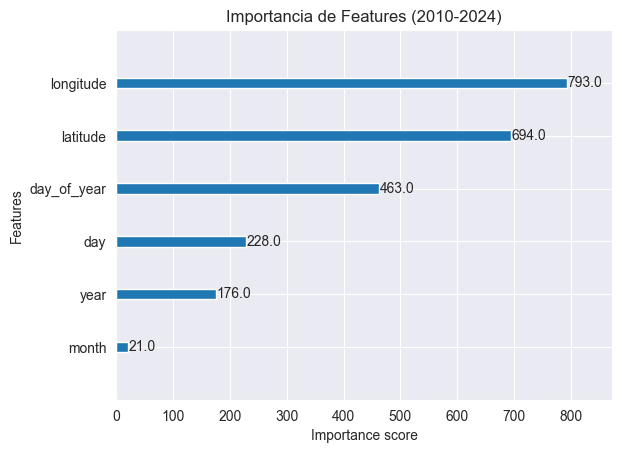

In [8]:
# Métricas
print("Accuracy (2020-2024):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión (2010-2024)')
plt.show()

# Feature importance
xgb.plot_importance(model)
plt.title('Importancia de Features (2010-2024)')
plt.show()